# Design for Co-Factor Swapping

In [1]:
from cameo.strain_design.heuristic.evolutionary_based import CofactorSwapOptimization

## Setup Model

In [2]:
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite

In [3]:
# Loading of the model
model = read_sbml_model('data/yeastGEM_het.xml')

In [4]:
with model:
    base_max_growth = model.slim_optimize()
    print(base_max_growth)
    model.objective = model.reactions.R07215
    base_max_production = model.slim_optimize()
    print(base_max_production)

0.08374778664999827
0.041173424848048486


An updated and thus slightly larger model is also available.

In [5]:
model

Name,M_yeastGEM_v8__46__4__46__2
Memory address,0x01d363bc2130
Number of metabolites,2745
Number of reactions,4064
Number of groups,90
Objective expression,1.0*r_2111 - 1.0*r_2111_reverse_58b69
Compartments,"cell envelope, cytoplasm, extracellular, mitochondrion, nucleus, peroxisome, endoplasmic reticulum, Golgi, lipid particle, vacuole, endoplasmic reticulum membrane, vacuolar membrane, Golgi membrane, mitochondrial membrane"


In [6]:
model.solver = "glpk"

In [7]:
biomass = model.reactions.r_2111

It is probably desirable to account for a growth coupled design. Ideally the value chosen here should correspond to the region chosen in the production envelope.

In [8]:
biomass.lower_bound = 0.1

In [9]:
target = model.metabolites.get_by_id("7-Dehydrocholesterol_c")

In [10]:
demand = model.reactions.get_by_id("DM_7-Dehydrocholesterol_c")

In [11]:
model.objective = demand

In [12]:
from cameo.strain_design.heuristic.evolutionary.objective_functions import product_yield

In [13]:
prod_yield = product_yield(model.reactions.R07215, model.reactions.r_1714)
print(prod_yield)

By default this method looks to replace NADH and NADPH. You can set different co-factor pairs via the parameter `cofactor_id_swaps=([from], [to])` which requires the metabolite identifiers in the model of the pairs that you want to swap. Please look at the documentation for more info.

In [14]:
# Since our model uses other names for the co-factors, here are the names in our model:

# NADH  = s_1203[c]
# NAD+  = s_1198[c]

# NADPH    = s_1212[c]
# NADP+    = s_1207[c]

In [15]:
# Swap NADPH to NADH
#                                                                                            cofactor_id_swaps=(['nad_c', 'nadh_c'], ['nadp_c', 'nadph_c']),
swap_opt = CofactorSwapOptimization(model=model, objective_function = prod_yield, plot=True, cofactor_id_swaps=(['s_1198[c]', 's_1203[c]'], ['s_1207[c]', 's_1212[c]']))

In [16]:
%%time
result = swap_opt.run(max_size=5)

Starting optimization at Tue, 01 Dec 2020 20:45:43


HBox()

Finished after 00:02:23
Wall time: 5min 25s


In [17]:
result

,index,targets,fitness
0,0,"(r_0659,)",0.090048


We can now try to remake the r_0659 reaction to increase the fluxes.

In [18]:
model.reactions.r_0659

Reaction identifier,r_0659
Name,isocitrate dehydrogenase (NADP)
Memory address,0x01d36c3ab6d0
Stoichiometry,s_0940[c] + s_1207[c] <=> s_0180[c] + s_0456[c] + s_1212[c] isocitrate [cytoplasm] + NADP(+) [cytoplasm] <=> 2-oxoglutarate [cytoplasm] + carbon dioxide [cytoplasm] + NADPH [cytoplasm]
GPR,YLR174W
Lower bound,-1000.0
Upper bound,1000.0


In [19]:
reaction1 = Reaction('r_0659_swap')

# The reactions uses:
## s_0940[c] + s_1207[c] <=> s_0180[c] + s_0456[c] + s_1212[c]
## isocitrate [cytoplasm] + NADP(+) [cytoplasm] <=> 2-oxoglutarate [cytoplasm] + carbon dioxide [cytoplasm] + NADPH [cytoplasm]

# We can change the NADP+ to NAD+ and the NADPH to NADH
# NADH  = s_1203[c]
# NAD+  = s_1198[c]

# NADPH    = s_1212[c]
# NADP+    = s_1207[c]


# We can now define the reaction stoichiometry
# In this, we will define the left side to be the substrates
reaction1.add_metabolites({
                            model.metabolites.get_by_id("s_0940[c]"): -1,
                            model.metabolites.get_by_id("s_1198[c]"): -1,
                            model.metabolites.get_by_id("s_0180[c]"): 1,
                            model.metabolites.get_by_id("s_0456[c]"): 1,
                            model.metabolites.get_by_id("s_1203[c]"): 1
                             })

model.add_reactions([reaction1])

# Since the reaction has bounds of -1000 to 1000, we are also setting that here
model.reactions.r_0659_swap.bounds = -1000, 1000

In [20]:
model.reactions.r_0659_swap

Reaction identifier,r_0659_swap
Name,
Memory address,0x01d36ddd0070
Stoichiometry,s_0940[c] + s_1198[c] <=> s_0180[c] + s_0456[c] + s_1203[c] isocitrate [cytoplasm] + NAD [cytoplasm] <=> 2-oxoglutarate [cytoplasm] + carbon dioxide [cytoplasm] + NADH [cytoplasm]
GPR,
Lower bound,-1000
Upper bound,1000


In [21]:
model.reactions.r_0659

Reaction identifier,r_0659
Name,isocitrate dehydrogenase (NADP)
Memory address,0x01d36c3ab6d0
Stoichiometry,s_0940[c] + s_1207[c] <=> s_0180[c] + s_0456[c] + s_1212[c] isocitrate [cytoplasm] + NADP(+) [cytoplasm] <=> 2-oxoglutarate [cytoplasm] + carbon dioxide [cytoplasm] + NADPH [cytoplasm]
GPR,YLR174W
Lower bound,-1000.0
Upper bound,1000.0


In [ ]:
# We can now repeat the process

reaction2 = Reaction('r_0163_swap')

# The reactions uses:
## s_0680[c] + s_1198[c] --> s_0359[c] + s_0794[c] + s_1203[c]
## ethanol [cytoplasm] + NAD [cytoplasm] --> acetaldehyde [cytoplasm] + H+ [cytoplasm] + NADH [cytoplasm]

# We can change the NAD+ to NADp+ and the NADH to NADPH
# NADH  = s_1203[c]
# NAD+  = s_1198[c]

# NADPH    = s_1212[c]
# NADP+    = s_1207[c]


# We can now define the reaction stoichiometry
# In this, we will define the left side to be the substrates
reaction2.add_metabolites({
                            model.metabolites.get_by_id("s_0680[c]"): -1,
                            model.metabolites.get_by_id("s_1207[c]"): -1,
                            model.metabolites.get_by_id("s_0359[c]"): 1,
                            model.metabolites.get_by_id("s_0794[c]"): 1,
                            model.metabolites.get_by_id("s_1212[c]"): 1
                             })

model.add_reactions([reaction2])


In [23]:
model.reactions.r_0659


Reaction identifier,r_0659
Name,isocitrate dehydrogenase (NADP)
Memory address,0x01d36c3ab6d0
Stoichiometry,s_0940[c] + s_1207[c] --> s_0180[c] + s_0456[c] + s_1212[c] isocitrate [cytoplasm] + NADP(+) [cytoplasm] --> 2-oxoglutarate [cytoplasm] + carbon dioxide [cytoplasm] + NADPH [cytoplasm]
GPR,YLR174W
Lower bound,0
Upper bound,0


In [22]:
model.reactions.r_0659.knock_out()


We can now run a quick test to see if the co-factor swap has done any difference

In [24]:
with model:
    swap_max_growth = model.slim_optimize()
    print(swap_max_growth)
    model.objective = model.reactions.R07215
    swap_max_production = model.slim_optimize()
    print(swap_max_production)

0.01286405589892623
0.012864000741975726


In [31]:
print("Max growth has changed by", round((swap_max_growth-(base_max_growth))/(base_max_growth) * 100, 2), "percent")
print("Max production has changed by", round((swap_max_production-(base_max_production))/(base_max_production) * 100, 2), "percent")

Max growth has changed by -84.64 percent
Max production has changed by -68.76 percent


In [27]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope, add_envelope
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 

In [28]:
# In this plot, we are looking at the dynamics between the 7-dehydrocholesterol creating reaction (R07215) and the biomass formation reaction (r_2111)
ppp_7DH = production_envelope(model,
                    reactions=[model.reactions.R07215],
                    objective=model.reactions.r_2111)

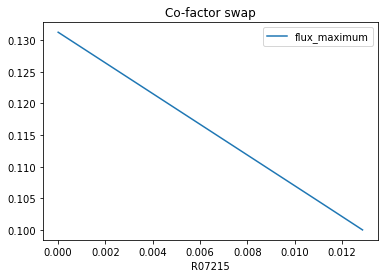

In [29]:
pppp = ppp_7DH.plot(x='R07215', y='flux_maximum')
fig = pppp.get_figure()
plt.title(label="Co-factor swap")
fig.savefig("figures/co-factor.png")

From this we can see that very little has changed in the PPP, but that the maximal production of both biomass and 7-dehydrocholesterol was increased. \
We will save this version of the model as "yeastGEM_het_swap.xml" for co-factor **swap**.

In [30]:
write_sbml_model(model, "data/yeastGEM_het_swap.xml")